# 04 - Train ML models

This notebook traines some ML models (1h ahead predictions and 1d ahead predictions) based on the previously created df_train.

STEPS:

- 04.01 - Import libraries
- 04.02 - Import df_train data
- 04.03 - Data preparation
- 04.04 - One hour ahead model
- 04.05 - One day ahead model
- 04.06 - Build the X_predict matrix

# 04.01 Import Libraries
Let's import the libraries we will be using.

In [1]:
import pandas as pd
import pytz
from dateutil import tz

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,5)
sns.set()

In [3]:
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor

# 04.02 Import df_train data
Import the df_train created in the Notebook 03.

In [4]:
# Df_train
df = pd.read_csv('sample-data/DF_TRAIN.csv')

# Correct timestamp format
df['Timestamp_NY'] = pd.to_datetime(df['Timestamp_NY'])

# Ensure values are sorted by date
df = df.sort_values('Timestamp_NY', ascending=True).reset_index(drop=True)

# Check the size and visualise some rows
print(df.shape)
df.head()

(4531, 22)


,Timestamp_NY,total_num_bikes_available,wind_kph,feelslike_temp_c,wind_kph_24,feelslike_temp_c_24,condition_Clear,condition_Clouds,condition_Rain,condition_Snow,...,condition_24_Rain,condition_24_Snow,year,month,day,hour,minute,dayofweek,target_1h,target_1d
0,2021-08-11 09:50:00-04:00,18621.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,9,50,2,18206.0,18239.0
1,2021-08-11 09:55:00-04:00,18668.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,9,55,2,18229.0,18338.0
2,2021-08-11 10:00:00-04:00,18763.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,0,2,18310.0,18440.0
3,2021-08-11 10:05:00-04:00,18712.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,5,2,18320.0,18438.0
4,2021-08-11 10:10:00-04:00,18722.0,7.884,4.25,14.256,8.02,1,0,0,0,...,0,0,2021,8,11,10,10,2,18303.0,18431.0


# 04.03 Data preparation
Let's prepare the data for the training. You can do this any way you want.

In [5]:
# Let's split the data in train-test simply chronologically
date_to_split = pd.to_datetime('20210824', format='%Y%m%d', errors='ignore').tz_localize(pytz.timezone('America/New_York')).astimezone(tz.gettz('America/New_York'))

df_train = df[df['Timestamp_NY']<date_to_split].dropna()
df_test = df[df['Timestamp_NY']>=date_to_split].dropna()
df_train.shape, df_test.shape

((3620, 22), (617, 22))

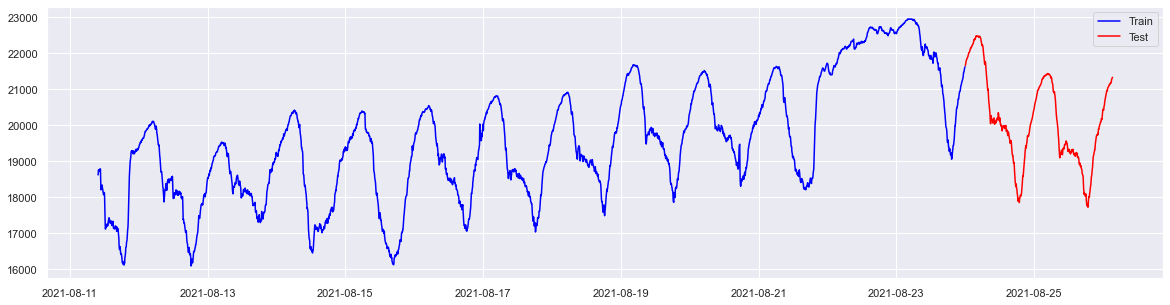

In [6]:
# Visually check complete dates
# The anormally high available bikes around the 22nd of August is due to https://www.nytimes.com/2021/08/23/nyregion/nyc-rain-storm-flooding-weather.html
plt.plot(df_train['Timestamp_NY'], df_train['total_num_bikes_available'], label='Train', color='blue')
plt.plot(df_test['Timestamp_NY'], df_test['total_num_bikes_available'], label='Test', color='red')
plt.legend()
plt.show()

# 04.04 - 1 hour ahead model
Let's create a model that predicts the amount of bikes in one hour.

You are free here to do it anyway you want! Alternatively, check our approach:

## 04.04.01 - Approach
Our approach here is going to be to use the current amount of bikes now to try to predict whether it will increase or decrease in the next hour. This is because the current amount of bikes is a reasonably good predictor of the amount of bikes in one hour.

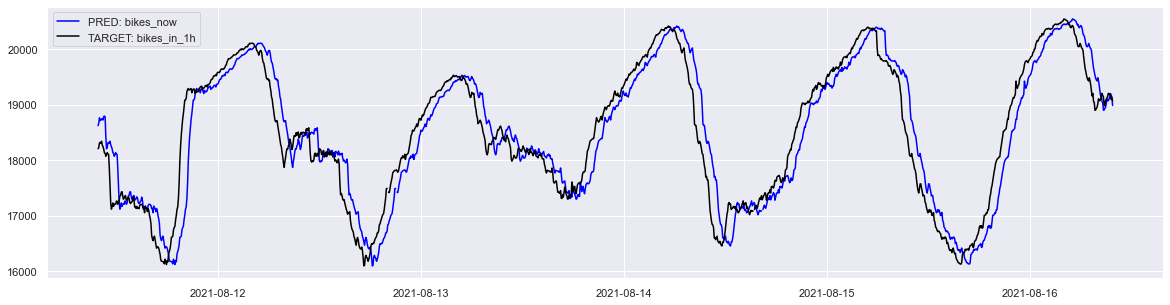

In [8]:
# Let's visually check how the current number of bikes predicts the amount of bikes in one hour (for 5 days)
plt.plot(df['Timestamp_NY'][:int(60/5*24*5)], df['total_num_bikes_available'][:int(60/5*24*5)], label='PRED: bikes_now', color='blue')
plt.plot(df['Timestamp_NY'][:int(60/5*24*5)], df['target_1h'][:int(60/5*24*5)], label='TARGET: bikes_in_1h', color='black')
plt.legend()
plt.show()

In [9]:
# Let's now measure it with the rmse
rmse = mean_squared_error(df.dropna()['target_1h'], df.dropna()['total_num_bikes_available'], squared=False)
print('RMSE: ', rmse)
print('That is, it averages a ' + str(round(rmse/df['total_num_bikes_available'].mean()*100,2)) + '% error.')

RMSE:  399.0199024343757
That is, it averages a 2.03% error.


This is a decent predictor, but can we improve it with ML models? Let's see if there's any pattern in the residuals:

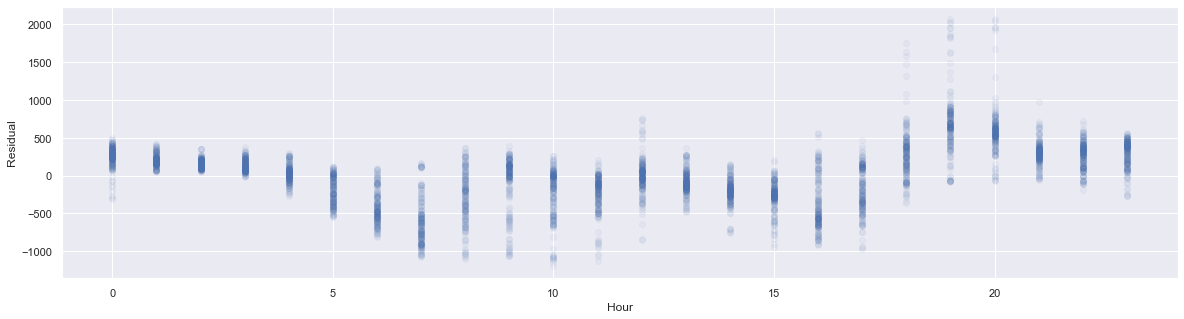

In [10]:
# Let's check if our current number of bikes misses the amount of bikes in one hour differently depending on the time of the day
plt.scatter(df['hour'], df['target_1h'] - df['total_num_bikes_available'], alpha = 0.05)
plt.xlabel('Hour')
plt.ylabel('Residual')
plt.show()

So, there is clearly some association. Let's try to capture it with a model.

## 04.04.02 - Train models
So, let's train some models based on the approach we have just gone through:

In [11]:
# Our models will try to predict the bikes difference between now and the next hour
y_train_1h = df_train['target_1h'] - df_train['total_num_bikes_available']
y_test_1h = df_test['target_1h'] - df_test['total_num_bikes_available']

In [12]:
# This function returns some basic metrics
def basic_quality_metrics(model, X_train, X_test, y_train, y_test, model_type='1h'):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = round(mean_squared_error(y_train, y_pred_train, squared=False), 2)
    print('RMSE train set:', rmse_train, rmse_train/y_train.abs().mean())
    
    rmse_test = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
    print('RMSE test set:', rmse_test, rmse_test/y_test.abs().mean())
    print('Test-train degradation: ' + str(round((rmse_test-rmse_train)/rmse_train*100,2)) + '%')
    
    plt.plot(df.dropna()['Timestamp_NY'], df.dropna()['target_'+model_type], color='black', label=model_type+' TARGET')
    plt.plot(df.dropna()['Timestamp_NY'], df.dropna()['total_num_bikes_available'], color='grey', label='Baseline current number bikes', linewidth=0.75)
    plt.plot(df_train.dropna()['Timestamp_NY'], df_train.dropna()['total_num_bikes_available'] + y_pred_train, color='blue', label='Train PRED')
    plt.plot(df_test.dropna()['Timestamp_NY'], df_test.dropna()['total_num_bikes_available'] + y_pred_test, color='red', label='Test PRED')
    plt.legend()
    plt.show()

RMSE train set: 195.32 0.650620273751855
RMSE test set: 183.17 0.562583448812123
Test-train degradation: -6.22%


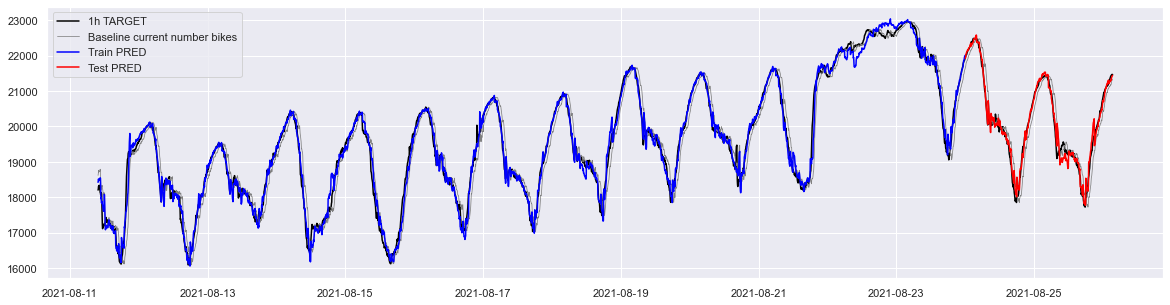

In [18]:
# Define cols to use
cols = ['hour', 'dayofweek']

# Define model hyperparameters
m1 = XGBRegressor(gamma=100)

# Model train
m1 = m1.fit(X=df_train[cols], y=y_train_1h)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m1, df_train[cols], df_test[cols], y_train_1h, y_test_1h)

RMSE train set: 143.82 0.4790713074492719
RMSE test set: 184.1 0.5654398259884906
Test-train degradation: 28.01%


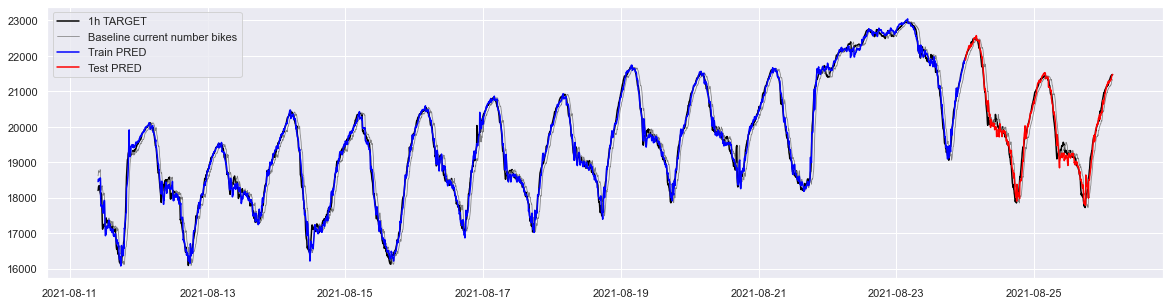

In [21]:
# Define cols to use
cols = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c']

# Define model hyperparameters
m2 = XGBRegressor(gamma=500000)

# Model train
m2 = m2.fit(X=df_train[cols], y=y_train_1h)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m2, df_train[cols], df_test[cols], y_train_1h, y_test_1h)

RMSE train set: 123.72 0.41211724487292395
RMSE test set: 199.13 0.6116025668065624
Test-train degradation: 60.95%


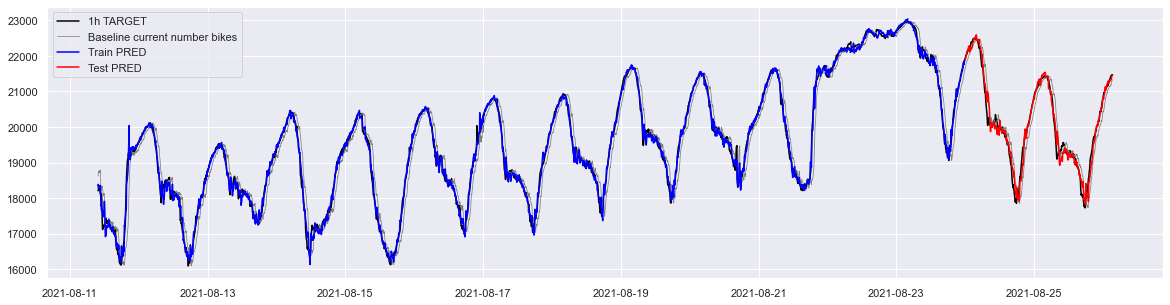

In [22]:
# Define cols to use
cols = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c', 'condition_Clear', 'condition_Clouds', 'condition_Rain', 'condition_Snow']

# Define model hyperparameters
m3 = XGBRegressor(gamma=200000)

# Model train
m3 = m3.fit(X=df_train[cols], y=y_train_1h)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m3, df_train[cols], df_test[cols], y_train_1h, y_test_1h)

In [16]:
cols_1 = ['hour', 'dayofweek']
cols_2 = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c']
cols_3 = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c', 'condition_Clear', 'condition_Clouds', 'condition_Rain', 'condition_Snow']

pd.DataFrame({'model': ['Baseline: bikes now', 'Model 1', 'Model 2', 'Model 3'], 
              'rmse train' : [mean_squared_error(df_train.dropna()['target_1h'], df_train.dropna()['total_num_bikes_available'], squared=False),
                              mean_squared_error(df_train.dropna()['target_1h'], df_train.dropna()['total_num_bikes_available']+m1.predict(df_train[cols_1]), squared=False),
                              mean_squared_error(df_train.dropna()['target_1h'], df_train.dropna()['total_num_bikes_available']+m2.predict(df_train[cols_2]), squared=False),
                              mean_squared_error(df_train.dropna()['target_1h'], df_train.dropna()['total_num_bikes_available']+m3.predict(df_train[cols_3]), squared=False)],
              'rmse test' : [mean_squared_error(df_test.dropna()['target_1h'], df_test.dropna()['total_num_bikes_available'], squared=False),
                              mean_squared_error(df_test.dropna()['target_1h'], df_test.dropna()['total_num_bikes_available']+m1.predict(df_test[cols_1]), squared=False),
                              mean_squared_error(df_test.dropna()['target_1h'], df_test.dropna()['total_num_bikes_available']+m2.predict(df_test[cols_2]), squared=False),
                              mean_squared_error(df_test.dropna()['target_1h'], df_test.dropna()['total_num_bikes_available']+m3.predict(df_test[cols_3]), squared=False)]})

,model,rmse train,rmse test
0,Baseline: bikes now,397.705742,406.644665
1,Model 1,195.493270,178.629935
2,Model 2,137.764541,172.094734
3,Model 3,123.720290,199.125119


All the models seem to perform fine (much better than the already decent baseline).

The model 1, with less variables seems to perform better in the test set (maybe with more historic date the weather info could help more, but it doesn't seem to be happening here).

So let's say we are happy with the model 1 and want to save it into Quix.
                                                                          
                                                    

### 04.04.03 Save model
Let's use the provided function to load our model into the Quix code repository.

In [266]:
from ML_Model_Save_FUNCTION import save_ML_model

In [267]:
token = "eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6Ik1qVTBRVE01TmtJNVJqSTNOVEpFUlVSRFF6WXdRVFF4TjBSRk56SkNNekpFUWpBNFFqazBSUSJ9.eyJodHRwczovL3F1aXguYWkvb3JnX2lkIjoicXVpeCIsImh0dHBzOi8vcXVpeC5haS9vd25lcl9pZCI6ImF1dGgwfGQ3ZDY0MWY4LTY5ZTktNDU2Zi1iYzcwLWI1YjMzN2U1OWVhZiIsImh0dHBzOi8vcXVpeC5haS90b2tlbl9pZCI6IjBkYmYzZDM5LWZmYzAtNGNmNC1hYWFmLWJlMzE0YjE1Yzk1NCIsImh0dHBzOi8vcXVpeC5haS9leHAiOiIyNTI0NjA0NDAwIiwiaXNzIjoiaHR0cHM6Ly9hdXRoLnF1aXguYWkvIiwic3ViIjoiQVRER1VHTTY4NjR0VXFCc3FmWW1kQ3RDelB1aml3TTJAY2xpZW50cyIsImF1ZCI6InF1aXgiLCJpYXQiOjE2Mjc1NjgwNTYsImV4cCI6MTYzMDE2MDA1NiwiYXpwIjoiQVRER1VHTTY4NjR0VXFCc3FmWW1kQ3RDelB1aml3TTIiLCJndHkiOiJjbGllbnQtY3JlZGVudGlhbHMiLCJwZXJtaXNzaW9ucyI6W119.DZB3HKI8CV1fzajWeyOW7mFvdWujQZdKTHm323FnpmZNutaab_1HN8mLalbXTpzgzxszBCE1Y6S3I6fk3IvZAaohWYh7ZvvbDB1gnHYpiqunOtzO874YLDQerMH3BX9h6LmlOy88Mg6KB-W_kMyhmhfvsdCuVmRto16wBfvewpP0LVR7QTQScHCK5a740sHcvSKEx-eO2mxaSu0EFfWBL7Kqmb5UKk_rETL7E5Qw3NniPQn-TQXc33ENFgKrEI_KYPySjLWp7ecMgyNb1Q-zlHFOH5ahNBVbvQ1vIzP-jMPGm-dmDSr1H3Do034PHCqp3jIrM0tgG5deS0l5rbzt_w"
workspace = "quix-nybikes"
project = 'NY-real-time-predictions'

save_ML_model(m1, "ML_1h_Forecast", workspace, project, token)

<Response [200]>


# 04.05 - 1 day ahead model
Again, go ahead and model this any way you want. Alternatively, check our approach:

## 04.05.01 - Approach
We are going to go ahead and repeat the 1 hour ahead approach, even when it may not be such a good idea for the 1 day ahead prediction. 

The point of this project is not to show how to model this problem but how to put models into production in real time with Quix :)

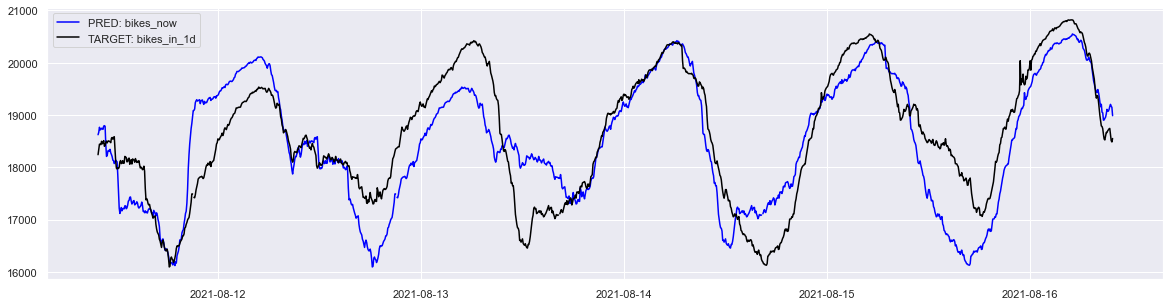

In [23]:
# Let's visually check how the current number of bikes predicts the amount of bikes in one day (for 5 days)
plt.plot(df['Timestamp_NY'][:int(60/5*24*5)], df['total_num_bikes_available'][:int(60/5*24*5)], label='PRED: bikes_now', color='blue')
plt.plot(df['Timestamp_NY'][:int(60/5*24*5)], df['target_1d'][:int(60/5*24*5)], label='TARGET: bikes_in_1d', color='black')
plt.legend()
plt.show()

In [24]:
# Let's now measure it with the rmse
rmse = mean_squared_error(df.dropna()['target_1d'], df.dropna()['total_num_bikes_available'], squared=False)
print('RMSE: ', rmse)
print('That is, it averages a ' + str(round(rmse/df['total_num_bikes_available'].mean()*100,2)) + '% error.')

RMSE:  1023.099241014383
That is, it averages a 5.21% error.


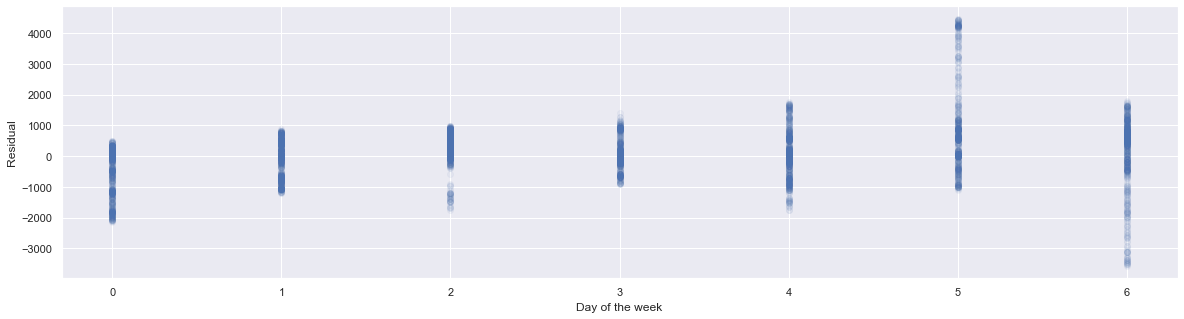

In [25]:
# Let's check if our current number of bikes misses the amount of bikes in one day differently depending on the day of the week
plt.scatter(df['dayofweek'], df['target_1d'] - df['total_num_bikes_available'], alpha = 0.05)
plt.xlabel('Day of the week')
plt.ylabel('Residual')
plt.show()

So, there is clearly some association, although less powerfull than in the 1 hour ahead residual. 

Let's try to capture it with a model.

## 04.05.02 - Train models
So, let's train some models based on the approach just discussed:

In [26]:
# This function returns some basic metrics
def basic_quality_metrics_2(model, X_train, X_test, y_train, y_test, model_type='1d'):
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    rmse_train = round(mean_squared_error(y_train, y_pred_train, squared=False), 2)
    print('RMSE train set:', rmse_train, rmse_train/y_train.abs().mean())
    
    rmse_test = round(mean_squared_error(y_test, y_pred_test, squared=False), 2)
    print('RMSE test set:', rmse_test, rmse_test/y_test.abs().mean())
    print('Test-train degradation: ' + str(round((rmse_test-rmse_train)/rmse_train*100,2)) + '%')
    
    plt.plot(df.dropna()['Timestamp_NY'], df.dropna()['target_'+model_type], color='black', label=model_type+' TARGET')
    plt.plot(df.dropna()['Timestamp_NY'], df.dropna()['total_num_bikes_available'], color='grey', label='Baseline current number bikes', linewidth=0.75)
    plt.plot(df_train.dropna()['Timestamp_NY'], y_pred_train, color='blue', label='Train PRED')
    plt.plot(df_test.dropna()['Timestamp_NY'], y_pred_test, color='red', label='Test PRED')
    plt.legend()
    plt.show()

In [40]:
# Our models will try to predict the bikes difference between now and the next hour
y_train_1d = df_train['target_1d'] - df_train['total_num_bikes_available']
y_test_1d = df_test['target_1d'] - df_test['total_num_bikes_available']

In [42]:
df.columns

Index(['Timestamp_NY', 'total_num_bikes_available', 'wind_kph',
       'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24',
       'condition_Clear', 'condition_Clouds', 'condition_Rain',
       'condition_Snow', 'condition_24_Clear', 'condition_24_Clouds',
       'condition_24_Rain', 'condition_24_Snow', 'year', 'month', 'day',
       'hour', 'minute', 'dayofweek', 'target_1h', 'target_1d'],
      dtype='object')

RMSE train set: 958.78 1.289375534925033
RMSE test set: 845.46 1.5800573412389631
Test-train degradation: -11.82%


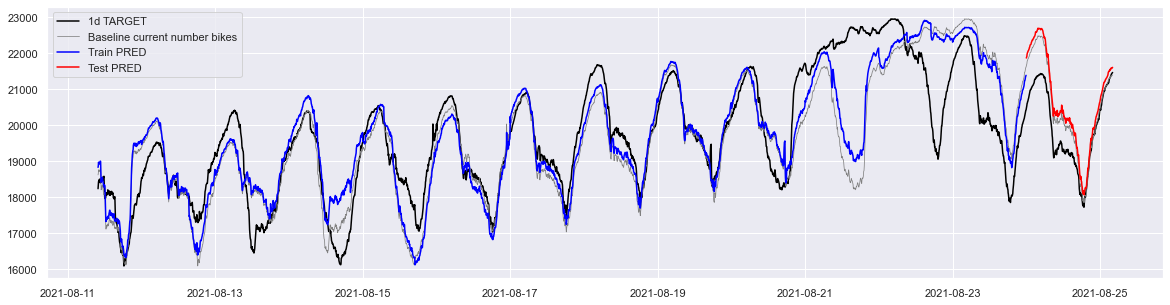

In [49]:
# Define cols to use
cols = ['hour', 'dayofweek']

# Define model hyperparameters
m_1d_1 = XGBRegressor(gamma=100000000)

# Model train
m_1d_1 = m_1d_1.fit(X=df_train[cols], y=y_train_1d)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m_1d_1, df_train[cols], df_test[cols], y_train_1d, y_test_1d, model_type='1d')

RMSE train set: 1072.94 1.4428988782019496
RMSE test set: 799.06 1.4933416354297138
Test-train degradation: -25.53%


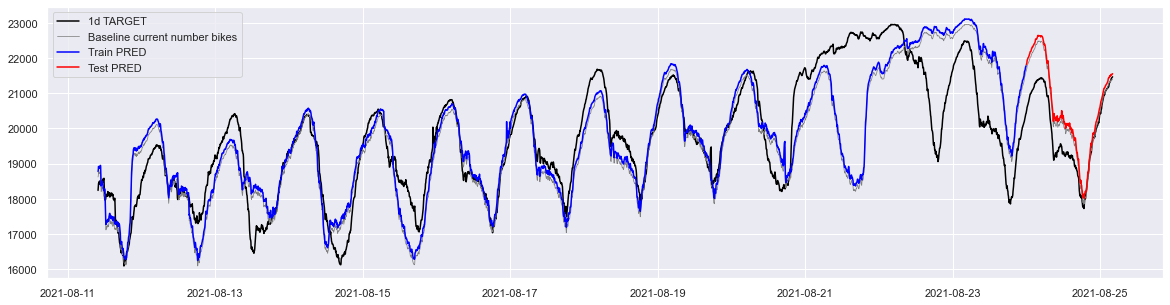

In [50]:
# Define cols to use
cols = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24']

# Define model hyperparameters
m_1d_2 = XGBRegressor(gamma=1000000000)

# Model train
m_1d_2 = m_1d_2.fit(X=df_train[cols], y=y_train_1d)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m_1d_2, df_train[cols], df_test[cols], y_train_1d, y_test_1d, model_type='1d')

RMSE train set: 1072.94 1.4428988782019496
RMSE test set: 799.06 1.4933416354297138
Test-train degradation: -25.53%


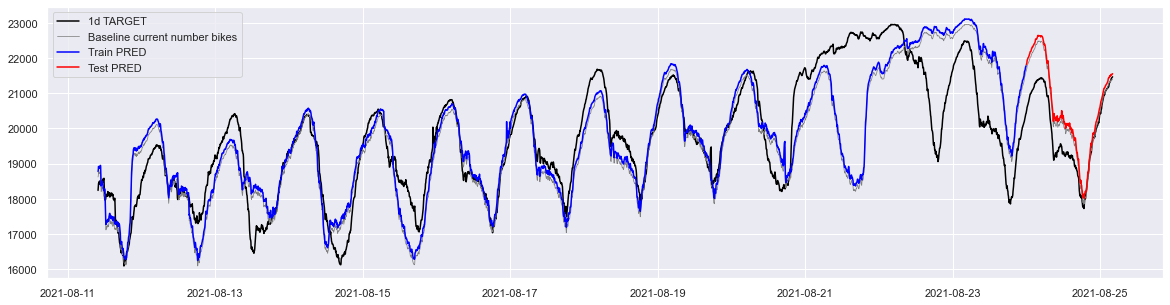

In [51]:
# Define cols to use
cols = ['hour', 'dayofweek', 'total_num_bikes_available', 'wind_kph',
       'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24',
       'condition_Clear', 'condition_Clouds', 'condition_Rain',
       'condition_Snow', 'condition_24_Clear', 'condition_24_Clouds',
       'condition_24_Rain', 'condition_24_Snow']

# Define model hyperparameters
m_1d_3 = XGBRegressor(gamma=5000000000)

# Model train
m_1d_3 = m_1d_3.fit(X=df_train[cols], y=y_train_1d)

# Entrenamos y predecimos con dicho modelo
basic_quality_metrics(m_1d_3, df_train[cols], df_test[cols], y_train_1d, y_test_1d, model_type='1d')

In [52]:
cols_1 = ['hour', 'dayofweek']
cols_2 = ['hour', 'dayofweek', 'wind_kph', 'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24']
cols_3 = ['hour', 'dayofweek', 'total_num_bikes_available', 'wind_kph', 'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24', 'condition_Clear', 'condition_Clouds', 'condition_Rain', 'condition_Snow', 'condition_24_Clear', 'condition_24_Clouds', 'condition_24_Rain', 'condition_24_Snow']
pd.DataFrame({'model': ['Baseline: bikes now', 'Model 1', 'Model 2', 'Model 3'], 
              'rmse train' : [mean_squared_error(df_train.dropna()['target_1d'], df_train.dropna()['total_num_bikes_available'], squared=False),
                              mean_squared_error(df_train.dropna()['target_1d'], df_train.dropna()['total_num_bikes_available']+m_1d_1.predict(df_train[cols_1]), squared=False),
                              mean_squared_error(df_train.dropna()['target_1d'], df_train.dropna()['total_num_bikes_available']+m_1d_2.predict(df_train[cols_2]), squared=False),
                              mean_squared_error(df_train.dropna()['target_1d'], df_train.dropna()['total_num_bikes_available']+m_1d_3.predict(df_train[cols_3]), squared=False)],
              'rmse test' : [mean_squared_error(df_test.dropna()['target_1d'], df_test.dropna()['total_num_bikes_available'], squared=False),
                              mean_squared_error(df_test.dropna()['target_1d'], df_test.dropna()['total_num_bikes_available']+m_1d_1.predict(df_test[cols_1]), squared=False),
                              mean_squared_error(df_test.dropna()['target_1d'], df_test.dropna()['total_num_bikes_available']+m_1d_2.predict(df_test[cols_2]), squared=False),
                              mean_squared_error(df_test.dropna()['target_1d'], df_test.dropna()['total_num_bikes_available']+m_1d_3.predict(df_test[cols_3]), squared=False)]})

,model,rmse train,rmse test
0,Baseline: bikes now,1084.248493,672.056100
1,Model 1,958.777250,845.457103
2,Model 2,1072.941181,799.064394
3,Model 3,1072.941181,799.064394


Again, the Model 1 seems to be the most consisten one. So let's save that one into our Quix repository.

### 04.05.03 Save model
Let's use the provided function to load our model into the Quix code repository.

In [278]:
from ML_Model_Save_FUNCTION import save_ML_model

In [279]:
token = "eyJhbGciOiJSUzI1NiIsInR5cCI6IkpXVCIsImtpZCI6Ik1qVTBRVE01TmtJNVJqSTNOVEpFUlVSRFF6WXdRVFF4TjBSRk56SkNNekpFUWpBNFFqazBSUSJ9.eyJodHRwczovL3F1aXguYWkvb3JnX2lkIjoicXVpeCIsImh0dHBzOi8vcXVpeC5haS9vd25lcl9pZCI6ImF1dGgwfGQ3ZDY0MWY4LTY5ZTktNDU2Zi1iYzcwLWI1YjMzN2U1OWVhZiIsImh0dHBzOi8vcXVpeC5haS90b2tlbl9pZCI6IjBkYmYzZDM5LWZmYzAtNGNmNC1hYWFmLWJlMzE0YjE1Yzk1NCIsImh0dHBzOi8vcXVpeC5haS9leHAiOiIyNTI0NjA0NDAwIiwiaXNzIjoiaHR0cHM6Ly9hdXRoLnF1aXguYWkvIiwic3ViIjoiQVRER1VHTTY4NjR0VXFCc3FmWW1kQ3RDelB1aml3TTJAY2xpZW50cyIsImF1ZCI6InF1aXgiLCJpYXQiOjE2Mjc1NjgwNTYsImV4cCI6MTYzMDE2MDA1NiwiYXpwIjoiQVRER1VHTTY4NjR0VXFCc3FmWW1kQ3RDelB1aml3TTIiLCJndHkiOiJjbGllbnQtY3JlZGVudGlhbHMiLCJwZXJtaXNzaW9ucyI6W119.DZB3HKI8CV1fzajWeyOW7mFvdWujQZdKTHm323FnpmZNutaab_1HN8mLalbXTpzgzxszBCE1Y6S3I6fk3IvZAaohWYh7ZvvbDB1gnHYpiqunOtzO874YLDQerMH3BX9h6LmlOy88Mg6KB-W_kMyhmhfvsdCuVmRto16wBfvewpP0LVR7QTQScHCK5a740sHcvSKEx-eO2mxaSu0EFfWBL7Kqmb5UKk_rETL7E5Qw3NniPQn-TQXc33ENFgKrEI_KYPySjLWp7ecMgyNb1Q-zlHFOH5ahNBVbvQ1vIzP-jMPGm-dmDSr1H3Do034PHCqp3jIrM0tgG5deS0l5rbzt_w"
workspace = "quix-nybikes"
project = 'NY-real-time-predictions'

save_ML_model(m_1d_1, "ML_1day_Forecast", workspace, project, token)

<Response [200]>


# 04.06 - Build the X_predict matrix
Let's see how to build the df_predict matrix from the real time data we will be getting:

## 04.06.01 - Fake weatherand bikes data
Let's build some fake dataframes in the same format we will be receiving them:

In [53]:
df_weather = pd.DataFrame({'Timestamp_NY': [1627629062729283000, 1627629062729283000], 
                         'feelslike_temp_c': [11.11, 10.40], 
                         'wind_kph': [14.652, 10.908], 
                         'condition': ['Clouds', 'Clouds'], 
                         'TAG__Forecast': ['Current', 'NextDay']})
df_weather

,Timestamp_NY,feelslike_temp_c,wind_kph,condition,TAG__Forecast
0,1627629062729283000,11.11,14.652,Clouds,Current
1,1627629062729283000,10.40,10.908,Clouds,NextDay


In [54]:
df_bikes = pd.DataFrame({'Timestamp_NY': [1627629065341108000], 
                         'total_num_bikes_available': [21432.0], 'num_docks_available': [25183.0]})
df_bikes

,Timestamp_NY,total_num_bikes_available,num_docks_available
0,1627629065341108000,21432.0,25183.0


In [55]:
from datetime import datetime,  timezone, timedelta
from dateutil import tz

# Get current time in New York
current_time = datetime.now(timezone.utc)
current_ny_time = pd.to_datetime(current_time).astimezone(tz.gettz('America/New_York'))
current_ny_time

Timestamp('2021-08-26 04:18:48.991836-0400', tz='dateutil/US/Eastern')

## 04.06.02 - Build X_predict function
Create function that generates X_predict dataframe out the bikes and weather dataframes.

In [56]:
def get_X_predict(current_ny_time, df_weather, df_bikes):    
    
    # Add timestamp
    df_X = pd.DataFrame({'timestamp_ny': [current_ny_time]})
    
    # Add current number of bikes
    df_X['total_num_bikes_available'] = int(df_bikes.loc[0,'total_num_bikes_available'])
    
    # Add weather variables 
    df_X['feelslike_temp_c'] = float(df_weather.loc[df_weather['TAG__Forecast']=='Current', 'feelslike_temp_c'])
    df_X['wind_kph'] = float(df_weather.loc[df_weather['TAG__Forecast']=='Current', 'wind_kph'])
    df_X['feelslike_temp_c_24'] = float(df_weather.loc[df_weather['TAG__Forecast']=='NextDay', 'feelslike_temp_c'])
    df_X['wind_kph_24'] = float(df_weather.loc[df_weather['TAG__Forecast']=='NextDay', 'wind_kph'])
    
    for col_i in ['condition_Clear', 'condition_Clouds', 'condition_Rain', 'condition_Snow']:
        if col_i.split('_')[-1] == str(df_weather.loc[df_weather['TAG__Forecast']=='Current', 'condition'][0]):
            df_X[col_i] = 1
        else:
            df_X[col_i] = 0
            
    for col_i in ['condition_24_Clear', 'condition_24_Clouds', 'condition_24_Rain', 'condition_24_Snow']:
        if col_i.split('_')[-1] == str(df_weather.loc[df_weather['TAG__Forecast']=='NextDay', 'condition'][1]):
            df_X[col_i] = 1
        else:
            df_X[col_i] = 0
    
    # Add time variables
    df_X['year'] = df_X['timestamp_ny'].dt.year
    df_X['month'] = df_X['timestamp_ny'].dt.month
    df_X['day'] = df_X['timestamp_ny'].dt.day
    df_X['hour'] = df_X['timestamp_ny'].dt.hour
    df_X['minute'] = df_X['timestamp_ny'].dt.minute
    df_X['dayofweek'] = df_X['timestamp_ny'].dt.dayofweek
    
    cols_to_return = ['timestamp_ny', 'total_num_bikes_available', 
                      'wind_kph', 'feelslike_temp_c', 'wind_kph_24', 'feelslike_temp_c_24',
                      'condition_Clear', 'condition_Clouds', 'condition_Rain', 'condition_Snow', 
                      'condition_24_Clear', 'condition_24_Clouds', 'condition_24_Rain', 'condition_24_Snow', 
                      'year', 'month', 'day', 'hour', 'minute', 'dayofweek']
    
    return df_X[cols_to_return]

In [57]:
df_X = get_X_predict(current_ny_time, df_weather, df_bikes)
df_X

,timestamp_ny,total_num_bikes_available,wind_kph,feelslike_temp_c,wind_kph_24,feelslike_temp_c_24,condition_Clear,condition_Clouds,condition_Rain,condition_Snow,condition_24_Clear,condition_24_Clouds,condition_24_Rain,condition_24_Snow,year,month,day,hour,minute,dayofweek
0,2021-08-26 04:18:48.991836-04:00,21432,14.652,11.11,10.908,10.4,0,1,0,0,0,1,0,0,2021,8,26,4,18,3


## 04.06.03 Try model predictions
It seems to be working! Let's see how we would do our model predictions:

In [62]:
current_n_bikes = int(df_bikes.loc[0, 'total_num_bikes_available'])
current_n_bikes

21432

In [63]:
cols = ['hour', 'dayofweek']

df_pred_1h = pd.DataFrame({
    'timestamp_ny': [current_ny_time + timedelta(hours=1)], 
    'timestamp_ny_execution': [str(current_ny_time)], 
    'forecast_1d': [current_n_bikes + int(m1.predict(df_X[cols]))]})

df_pred_1h

,timestamp_ny,timestamp_ny_execution,forecast_1d
0,2021-08-26 05:18:48.991836-04:00,2021-08-26 04:18:48.991836-04:00,21406


In [64]:
cols = ['hour', 'dayofweek']

df_pred_1day = pd.DataFrame({
    'timestamp_ny': [current_ny_time + timedelta(hours=24)], 
    'timestamp_ny_execution': [str(current_ny_time)], 
    'forecast_1d': [current_n_bikes + int(m_1d_1.predict(df_X[cols]))]})

df_pred_1day

,timestamp_ny,timestamp_ny_execution,forecast_1d
0,2021-08-27 04:18:48.991836-04:00,2021-08-26 04:18:48.991836-04:00,21523
